<h1>Automated Flood Detection based on Satellite Images</h1>
<br>
This project focuses on flood detection using only the SEN2 data from the SEN12-FLOOD dataset. The goal is to process Sentinel-2 satellite images, specifically four spectral bands: Band2 (blue), Band3 (green), Band4 (red), and Band8 (infrared). These bands are important for distinguishing between land, water, and other surface features. The process involves organizing the data, checking for empty images, and stacking the bands together for further analysis, which will be used for flood detection tasks.
<br>
<hr>
Dataset:<br>
Clément Rambour, Nicolas Audebert, Elise Koeniguer, Bertrand Le Saux, Michel Crucianu, Mihai Datcu. (2020). SEN12-FLOOD : a SAR and Multispectral Dataset for Flood Detection . IEEE Dataport. https://dx.doi.org/10.21227/w6xz-s898

Download (after free registration) - 12,2Gb: https://ieee-dataport.org/open-access/sen12-flood-sar-and-multispectral-dataset-flood-detection


---

<h2>Import of used packages</h2>

Run the following command to install required packages:
'pip install rasterio opencv-python torch torchvision tifffile tensorflow matplotlib'

In [59]:
#Helper packages
import rasterio
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import tifffile as tiff
import json
import random
import pandas as pd
import wandb

#For advanced solution 1
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorboard import program
import threading
import datetime

#For advanced solution 2
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import WeightedRandomSampler
from pytorch_lightning import Trainer
import gradio as gr
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score


---

<h2>Directory and file setup</h2>

This section must be executed if you are working with previously unprocessed data. The uploaded version should contain pre-processed data, which is more lightweight.

This function will check if the selected folder has a non-empty B02 file:

In [ ]:
def check_img_content(path):
    
    path = os.path.join(path, 'B02.tif')

    image = cv2.imread(path,0)

    if (cv2.countNonZero(image) == 0): return  True
    else: return  False

This function will delete the folder with contents on path (use with responsibility):

In [ ]:
def remove_folders(path):
    shutil.rmtree(path)

This function performs a series of file structure modifications, to transform the downloaded data before processing. It will also throw away unused files and the original folders.

In [4]:
def create_dir_structure(flist):
    for folder in flist:
        prefix = folder[:11]    # Extract prefix from folder name
        id = folder[11:]        # Extract id from folder name

        if len(id) > 4: continue # Skip if id length is more than 4, because the id can be at most 4 digits

        for file in os.listdir(folder):

            if file.startswith('S1'): 
                os.remove(os.path.join(prefix + id, file)) # Remove files starting with 'S1'
                continue

            # If the file is a spectral band (B02, B03, B04, B08)
            if file.endswith('B02.tif') or file.endswith('B03.tif') or file.endswith('B04.tif') or file.endswith('B08.tif'):
                date = file[3:13] # Extract date from file name
                newFolder =  os.path.join(prefix,'S2_' + id + '_'+ date) # Create new folder name

                if os.path.isdir(newFolder):
                    shutil.move(os.path.join(folder, file), os.path.join(newFolder, file[14:])) # Move file if folder exists
                    
                else:
                    os.mkdir(newFolder)     # Create folder if it doesn't exist
                    shutil.move(os.path.join(folder, file), os.path.join(newFolder, file[14:]))  # Move file

        remove_folders(folder) # Remove the original folder after moving files


This function will stack the 4 image bands into 1 output file, which will be used for training and testing:

In [5]:
def stack_bands(path):

    band_list = ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']
    try:
        
        # Read metadata from the first band (B02.tif) 
        with rasterio.open(os.path.join(path, band_list[0])) as src0:
            meta = src0.meta # Extract metadata from the first band
        
        # Update metadata to reflect the number of bands (layers) 
        meta.update(count = len(band_list))

       # Create a new stack file and write each band to it
        with rasterio.open(os.path.join(path, 'stack.tif'), 'w', **meta) as dst:
            for id, layer in enumerate(band_list, start=1):
                with rasterio.open(os.path.join(path, layer)) as src1:
                    dst.write_band(id, src1.read(1)) # Write each band to the stack file
    except:
        print("Folder with no Data") # Handle cases where the folder has no valid data 
        remove_folders(path) # Remove the folder if there's an issue
        
        pass # Continue without stopping on error 

Read and store the folder list:

In [6]:
folderList = []

rootdir = os.path.normpath('./SEN12FLOOD')  # Get the absolute path for the root directory
#rootdir = './SEN12FLOOD' 
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file) # Create the full path for each file/folder
    if os.path.isdir(d):    # Check if it's a folder
        folderList.append(d)     # Add folder to the list
        
# Print the total number of folders found        
print(f"The number of folders are currently = {len(folderList)}")

The number of folders are currently = 2039


Based on the original folder list, create the new structure. The function will ignore already transformed folders, running multiple times is safe.

In [ ]:
# Call the function to create the directory structure for the initial folder list (this can take minutes)
create_dir_structure(folderList)

Read and store the updated folder list:

In [4]:
folderList = []
#rootdir = './SEN12FLOOD'
rootdir = os.path.normpath('./SEN12FLOOD')
for file in os.listdir(rootdir):
     if 'S2_' in file:
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            folderList.append(d)
        
print(f"The number of folders are currently = {len(folderList)}")


The number of folders are currently = 2039


Based on the updated folder list, stack the selected bands:

In [ ]:
#Iterate through all folders and create a new image with 4 spectral bands:
#Band2 (blue), Band3 (green), Band4 (red), and Band8 (infrared)
#This process can take up to 2-5 minutes to complete

for folder_path in folderList:
    empty = check_img_content(folder_path) # Check if the folder contains empty images (all pixels are zero)
    if empty:
        remove_folders(folder_path) # Remove the folder if images are empty 
    else:
        stack_bands(folder_path) # Stack the spectral bands if images are valid

---

<h2>JSON Metadata Processing</h2>

Load the JSON content into the 'data' variable:

In [10]:
with open('./SEN12FLOOD/S2list.json', 'r') as file:
    data = json.load(file)

print( data)

{'0063': {'1': {'date': '2019-02-04', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-04'}, 'count': 1, 'folder': '0063', 'geo': {'type': 'Polygon', 'coordinates': [[[28.29722, -15.382762], [28.297507, -15.429039], [28.345216, -15.428755], [28.344918, -15.382479], [28.29722, -15.382762]]]}}, '0200': {'1': {'date': '2019-02-23', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-23'}, '2': {'date': '2019-02-28', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-28'}, '3': {'date': '2019-03-10', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-03-10'}, '4': {'date': '2019-03-25', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-03-25'}, '5': {'date': '2019-04-04', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-04-04'}, '6': {'date': '2019-04-14', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-04-14'}, '7': {'date': '2019-04-24', 'FLOODING': True, 'F

Iterate through the JSON structure, and write the FLOODING boolean attribute into the 'flooding.txt' file in each corresponfing folder:

In [11]:
for location_id, location_data in data.items():
    for location_date, date_data in location_data.items():
        if location_date == 'geo' or location_date =='count' or location_date =='folder': continue
        folder = os.path.join(rootdir, 'S2_' + location_id + '_' + date_data['date'])
        file = os.path.join(folder, 'flooding.txt')

        if os.path.isdir(folder):
            with open(file, 'w') as f:
                f.write(f"{date_data['FLOODING']}\n")

---

<h2>Data Augmentation</h2>

Composition of used transformations:

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15)
])

Applying the augmentation and creating the new files:

In [3]:
def augment_images_in_directory(input_dir):
    # Iterate through files in the specified directory
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file == 'stack.tif':  # Focus only on 'stack.tif' images
                file_path = os.path.join(root, file)
                
                # Load TIFF image with 4 channels (HxWxC)
                img = tiff.imread(file_path)
                
                # Convert image to tensor and rearrange to (CxHxW format for PyTorch)
                img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()
                # Apply augmentation
                img_transformed = train_transform(img_tensor)
                
                # Convert image back to (HxWxC format for numpy)
                img_transformed = img_transformed.permute(1, 2, 0).numpy().astype(np.uint16)
                
                # Save augmented image with new name: 'astack.tif'
                save_path = os.path.join(root, 'astack.tif')
                tiff.imwrite(save_path, img_transformed)

# Main execution
input_directory = './SEN12FLOOD'  # Root directory where the folders are located
augment_images_in_directory(input_directory)

---

<h2>Data loading</h2>

Setup

The getLabel function will return 0 or 1, depending whether the folder on 'path' contains FLOODED images or not.

We can define the train-test split ratio and the shuffle seed here.

Shuffle and split the folder list into separate folder lists for training and testing.

In [69]:
# Set random seed for reproducibility
random.seed(42)

# Function to get labels from text file
def getLabel(path):
    filepath = os.path.normpath(os.path.join(path, 'flooding.txt'))
    with open(filepath, 'r') as file:
        data = file.readline().strip()
        return 0 if data == "False" else 1

# Data loading setup
train_size = 0.7
shuffle_seed = 42

folderList = []
rootdir = os.path.normpath('./SEN12FLOOD')
for file in os.listdir(rootdir):
    if 'S2_' in file:
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            folderList.append(d)

size = len(folderList)
print(f"The number of folders are currently = {size}")

# Shuffle the data
random.shuffle(folderList)

test_start = round(size * train_size)
train_list = folderList[:test_start]
test_list = folderList[test_start:]

print(f"The number of folders for training are currently = {len(train_list)}")
print(f"The number of folders for testing are currently = {len(test_list)}")


The number of folders are currently = 2039
The number of folders for training are currently = 1427
The number of folders for testing are currently = 612


The load data function create the format necessary for further processing, based on train_list and test_list:

In [70]:
def load_data():
    images_train = []
    labels_train = []
    images_test = []
    labels_test = []

    # Load training data
    for folder in train_list:
        
        label = getLabel(folder)
        # Add original image
        imagePath = os.path.join(folder, "stack.tif")
        image = tiff.imread(imagePath)
        if image is not None:
            images_train.append(image)
            labels_train.append(label)

            
        # Add augmented image
        imagePath = os.path.join(folder, "astack.tif")
        image = tiff.imread(imagePath)
        if image is not None:
            images_train.append(image)
            labels_train.append(label)


    # Load test data
    for folder in test_list:
        # Add original image
        imagePath = os.path.join(folder, "stack.tif")
        image = tiff.imread(imagePath)
        if image is not None:
            images_test.append(image)
            # Add label
            label = getLabel(folder)
            labels_test.append(label)

    # Convert to numpy arrays and normalize
    images_train = np.array(images_train, dtype='float32') / 65535.0  # Augmentation applied as uint16, so normalize to float32
    labels_train = np.array(labels_train, dtype='int64')
    images_test = np.array(images_test, dtype='float32') / 65535.0  # Augmentation applied as uint16, so normalize to float32
    labels_test = np.array(labels_test, dtype='int64')

    return images_train, images_test, labels_train, labels_test
    

Load the data into X and y train and test arrays:

In [71]:
X_train, X_test, y_train, y_test = load_data()

Notice that X_train has double the rows as the training folders, as both the original and the augmented image is added.
Meanwhile the test data has the same number of rows as the test folder count:

In [7]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(2854, 512, 512, 4)
(2854,)
(612, 512, 512, 4)
(612,)


---

<h2>Data Analysis</h2>

The used band names in order of presence:

In [8]:
band_names = ["Blue", "Green", "Red", "NIR"]

This function prints information on the distribution of FLOODED and CLEAR data:

In [9]:
def analyzeLabels(labels):
    (unique, counts) = np.unique(labels, return_counts=True)

    print(f"FLOODED - images containing flooded areas in this dataset: {counts[1]}\n")
    print(f"CLEAR - images containing clear areas in this dataset: {counts[0]}\n")
    percentage = round(counts[1] / (counts[0] + counts[1]) * 100, 3)
    print(f"Percentage of FLOODED areas: " + str(percentage) + "%")

    return (unique, counts)

Analyze the 4 bands and their contribution to the stacked image:

In [10]:
def analyze_band_contributions(band_paths, stack_path):

    analysis = {}

    with rasterio.open(stack_path) as stack_src:
        stacked_data = stack_src.read()
        total_stack_sum = stacked_data.sum()

    for i, band_path in enumerate(band_paths):
        band_name = band_names[i] 

        with rasterio.open(band_path) as band_src:
            band_data = band_src.read(1)
     
        if stacked_data.shape[1:] != band_data.shape:
            raise ValueError(f"Shape mismatch for {band_name}: {band_data.shape} vs stack {stacked_data.shape[1:]}")

        band_sum = band_data.sum()
        contribution_ratio = band_sum / total_stack_sum
        band_mean = np.mean(band_data)
        band_std = np.std(band_data)

        analysis[band_name] = {
            "mean": band_mean,
            "std": band_std,
            "sum": band_sum,
            "contribution_ratio": contribution_ratio
        }

    return analysis


Iterate through the folder list and analyze the files in each one with the previous function:

In [11]:
def analyze_bands_in_folders(folder_list):

    analysis_results = {}

    for folder in folder_list:
        folder_name = os.path.basename(folder)

        band_paths = [os.path.join(folder, band) for band in ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']]
        stack_path = os.path.join(folder, "stack.tif")
        
        if not os.path.exists(stack_path):
            print(f"Warning: Stack file not found in {folder}")
            continue
        if not all(os.path.exists(band_path) for band_path in band_paths):
            print(f"Warning: Not all band files are present in {folder}")
            continue

        try:
            analysis = analyze_band_contributions(band_paths, stack_path)
            analysis_results[folder_name] = analysis
        except Exception as e:
            print(f"Error processing folder {folder_name}: {e}")

    return analysis_results


Aggregate the results provided for each folder, to get the global statistics:

In [12]:
def aggregate_contribution_results(results):

    data = []
    
    for folder, bands in results.items():
        for band, stats in bands.items():
            data.append({
                "Folder": folder,
                "Band": band,
                "Mean": stats["mean"],
                "Std Dev": stats["std"],
                "Contribution Ratio": stats["contribution_ratio"]
            })

    df = pd.DataFrame(data)

    aggregated_df = df.groupby("Band").agg(
        Mean=("Mean", "mean"),
        Mean_Std=("Mean", "std"),
        Std_Dev=("Std Dev", "mean"),
        Std_Dev_Std=("Std Dev", "std"),
        Mean_Contribution=("Contribution Ratio", "mean"),
        Std_Contribution=("Contribution Ratio", "std")
    ).sort_index()

    return aggregated_df


Visualize the means and stds:

In [65]:
def visualize_stacked_bar_chart(aggregated_results):
    # Extract data from DataFrame
    bands = aggregated_results.index.tolist()
    means = aggregated_results["Mean"].tolist()
    std_devs = aggregated_results["Std_Dev"].tolist()

    # Bar width and positions
    x = np.arange(len(bands))
    bar_width = 0.35

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, means, bar_width, label='Mean', color='skyblue')
    plt.bar(x + bar_width/2, std_devs, bar_width, label='Std Dev', color='orange')

    # Formatting
    plt.xticks(x, bands)
    plt.xlabel("Bands")
    plt.ylabel("Values")
    plt.title("Mean and Std Dev for Each Band")
    plt.legend()
    plt.show()

Visualize the aggregated contribution of each band to the stacked images on a pie chart:

In [63]:
def visualize_contribution_pie_chart(aggregated_df):
    # Reset index to ensure 'Band' is a column
    aggregated_df = aggregated_df.reset_index()
    
    # Extract bands and contributions
    bands = aggregated_df["Band"]
    contributions = aggregated_df["Mean_Contribution"]

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        contributions,
        labels=bands,
        autopct=lambda p: f"{p:.1f}%",
        startangle=90,
        colors=['blue', 'green', 'red', 'purple'],
        textprops={'fontsize': 12}
    )

    # Add title and formatting
    plt.title("Band Contribution Ratios (Pie Chart)", fontsize=14)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)

    plt.show()

Training data analysis:

In [14]:
train_CLEAR, train_FLOODED = analyzeLabels(y_train)

FLOODED - images containing flooded areas in this dataset: 668

CLEAR - images containing clear areas in this dataset: 2186

Percentage of FLOODED areas: 23.406%


Test data analysis:

In [ ]:
test_CLEAR, test_FLOODED = analyzeLabels(y_test)

Run the analysis on the actual folder list:

In [16]:
results = analyze_bands_in_folders(folderList)

Calculate the aggregated stats and sort the dataframe to the same order as the original bands:

In [ ]:
aggregated_results = aggregate_contribution_results(results)
aggregated_results = aggregated_results.sort_values(by="Band", ascending=True)
aggregated_results['index'] = [0,1,3,2]
aggregated_results = aggregated_results.sort_values(by="index", ascending=True)

Print the aggregated stats:

In [20]:
print(aggregated_results)

              Mean    Mean_Std     Std_Dev  Std_Dev_Std  Mean_Contribution  \
Band                                                                         
Blue    966.817836  842.038254  650.159605   751.937849           0.145687   
Green  1237.723634  788.780444  669.031039   693.297796           0.195453   
Red    1307.927038  816.425064  764.448707   643.335944           0.203666   
NIR    2651.157722  839.562039  850.634176   542.745068           0.455194   

       Std_Contribution  index  
Band                            
Blue           0.047117      0  
Green          0.037491      1  
Red            0.048612      2  
NIR            0.118846      3  


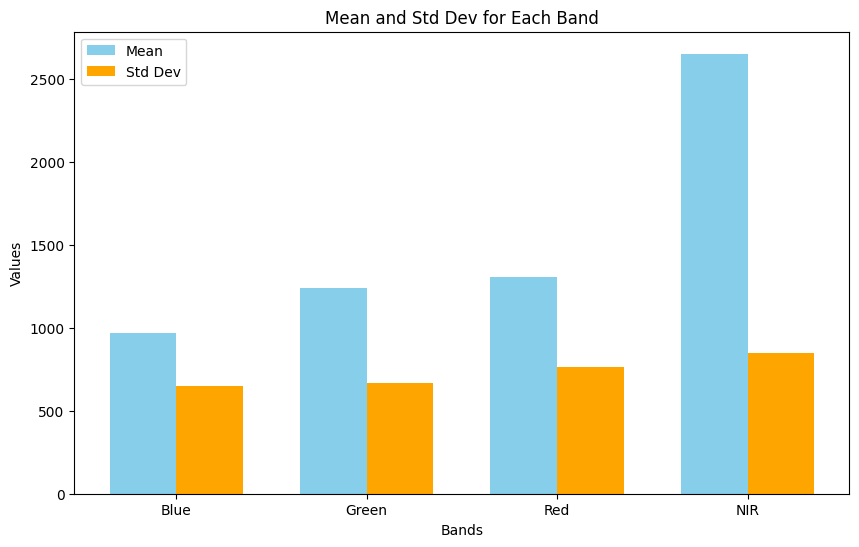

In [66]:
visualize_stacked_bar_chart(aggregated_results)

Display the contribution of the bands on a pie chart:

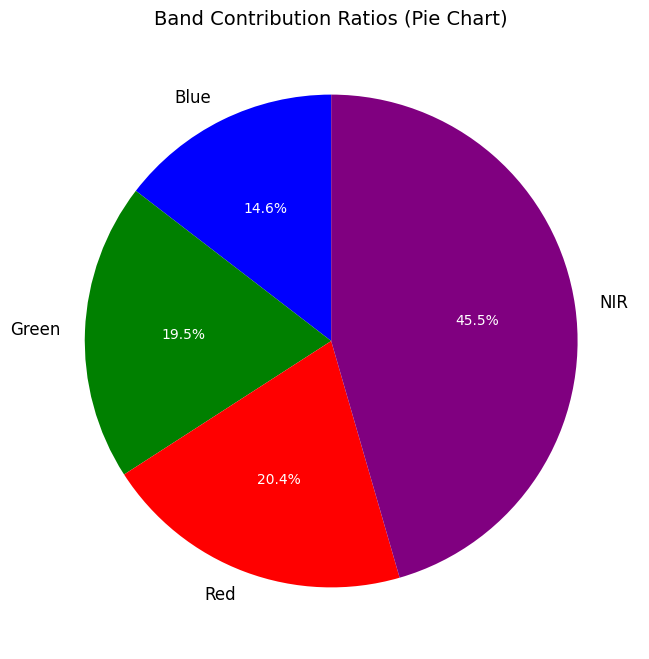

In [25]:
visualize_contribution_pie_chart(aggregated_results)

---

# Solution 1 (Upgraded Baseline)

## Keras Model

In [72]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [73]:
def start_tensorboard(log_dir):
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', log_dir])
    url = tb.launch()
    print(f"TensorBoard fut ezen a címen: {url}")

# Launching TensorBoard 
thread = threading.Thread(target=start_tensorboard, args=(log_dir,))
thread.start()

TensorBoard fut ezen a címen: http://localhost:6007/


In [74]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 4)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


C:\Users\totha\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [75]:
model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

---

## Training the Keras Model

Running the training:

In [76]:
history = model1.fit(
    X_train,
    y_train,
    batch_size=28,
    epochs=10,
    validation_split=1 - train_size,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.7323 - loss: 0.6938 - val_accuracy: 0.7783 - val_loss: 0.5574
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 94s 876ms/step - accuracy: 0.7864 - loss: 0.4372 - val_accuracy: 0.7783 - val_loss: 0.4315
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 886ms/step - accuracy: 0.8066 - loss: 0.4146 - val_accuracy: 0.7491 - val_loss: 0.4227
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 883ms/step - accuracy: 0.8169 - loss: 0.3730 - val_accuracy: 0.7631 - val_loss: 0.4021
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 64s 857ms/step - accuracy: 0.8112 - loss: 0.3871 - val_accuracy: 0.7690 - val_loss: 0.4266
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 68s 888ms/step - accuracy: 0.8681 - loss: 0.3151 - val_accuracy: 0.7596 - val_loss: 0.6137
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 65s 875ms/step - accuracy: 0.8798 - loss: 0.3221 - val_accuracy: 0.7725 - val_loss: 0.5213
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 63s 859ms/step - accuracy: 0.8973 - loss: 0.2427 - val_accura

In [77]:
model1.save('magellan_model_keras.keras')

---

## Evaluating the Keras Model

In [78]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

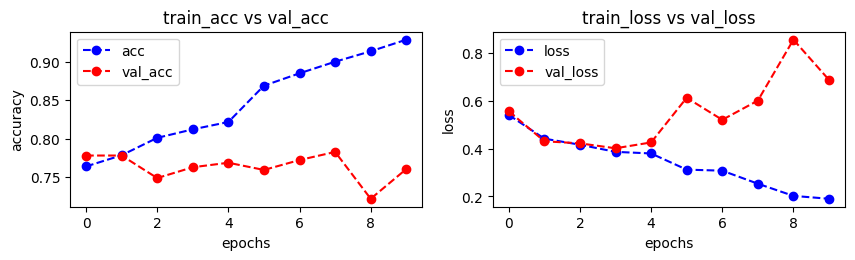

In [79]:
plot_accuracy_loss(history)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step


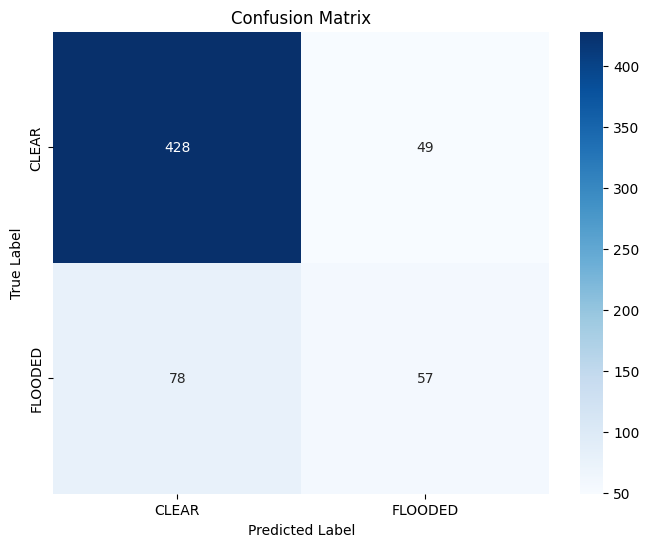

Accuracy: 0.79
Precision: 0.54
Recall: 0.42
F1-Score: 0.47

Metrics Summary:
            Metric  Count
0   True Positives     57
1   True Negatives    428
2  False Positives     49
3  False Negatives     78

Classification Report:
              precision    recall  f1-score   support

       CLEAR       0.85      0.90      0.87       477
     FLOODED       0.54      0.42      0.47       135

    accuracy                           0.79       612
   macro avg       0.69      0.66      0.67       612
weighted avg       0.78      0.79      0.78       612



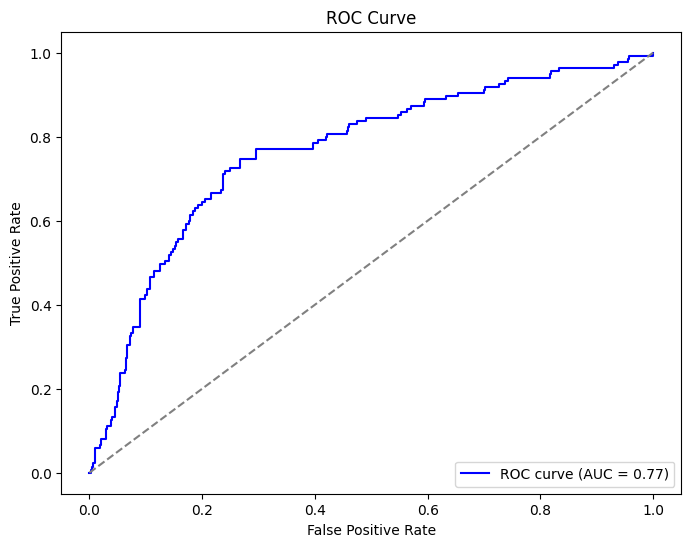

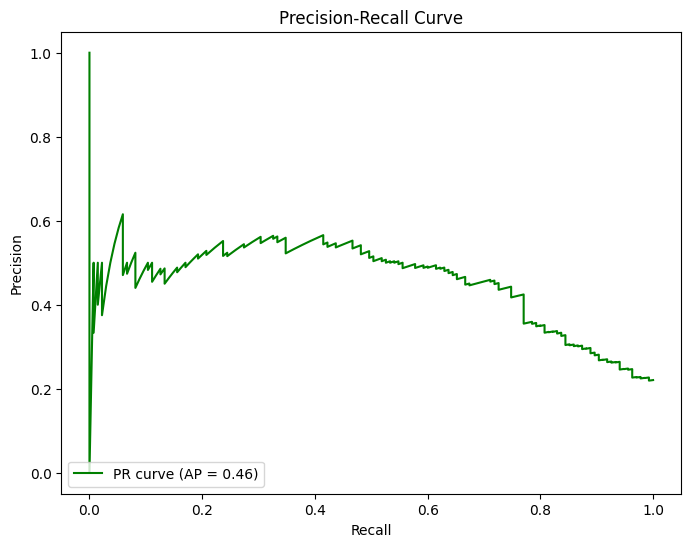

In [80]:
model = load_model("magellan_model_keras.keras")

# Get predictions for the entire test set
predictions = model1.predict(X_test)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["CLEAR", "FLOODED"], 
            yticklabels=["CLEAR", "FLOODED"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Calculate metrics
tp = conf_matrix[1, 1]  # True Positives
tn = conf_matrix[0, 0]  # True Negatives
fp = conf_matrix[0, 1]  # False Positives
fn = conf_matrix[1, 0]  # False Negatives

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

# Summary Table
summary = pd.DataFrame({
    "Metric": ["True Positives", "True Negatives", "False Positives", "False Negatives"],
    "Count": [tp, tn, fp, fn]
})
print("\nMetrics Summary:")
print(summary)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, predicted_classes, target_names=["CLEAR", "FLOODED"], zero_division=0))

# Compute ROC and Precision-Recall Curves
y_true_binary = (y_test == 1).astype(int)  # Convert labels to binary (0 or 1)
predicted_probabilities = predictions[:, 1]  # Use probabilities for the positive class (FLOODED)

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true_binary, predicted_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_true_binary, predicted_probabilities)
average_precision = average_precision_score(y_true_binary, predicted_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'PR curve (AP = {average_precision:.2f})')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()


### Gradio Interface

In [ ]:
# Load the trained model
model = load_model("magellan_model_keras.keras")

# Class labels
class_labels = ["CLEAR", "FLOODED"]

def classify_and_display_image(image_path):
    # Read the file
    image = tiff.imread(image_path.name)
    if image is None:
        return None, "Error: Unable to read image file."

    # Normalize the image
    image = image.astype('float32') / 65535.0

    # Ensure the image has the required shape (batch size, height, width, channels)
    if len(image.shape) == 3:  # If the image is HxWxC
        image = np.expand_dims(image, axis=0)  # Add batch dimension
    elif len(image.shape) == 2:  # If the image is grayscale HxW
        image = np.expand_dims(np.stack([image] * 4, axis=-1), axis=0)  # Make it 4 channels and add batch dimension
    else:
        return None, "Error: Image dimensions are not compatible."

    # Perform inference
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class

    # Convert the image to PIL format for display (show RGB channels)
    image_to_display = Image.fromarray((image[0, ..., :3] * 255).astype(np.uint8))

    # Return the image and classification label
    return image_to_display, class_labels[predicted_class]

# Gradio interface
interface = gr.Interface(
    fn=classify_and_display_image,
    inputs=gr.File(label="Upload a TIFF Image"),
    outputs=[
        gr.Image(type="pil", label="Uploaded Image"),  # Display the image
        gr.Textbox(label="Classification Result")      # Display the result
    ],
    title="Flood Classifier",
    description="Upload a TIFF image to classify it as CLEAR or FLOODED, and view the image."
)

# Launch the interface
interface.launch()


* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


---

# Solution 2

## PyTorch Model

Wandb is used mainly for tracking trainings and visualizations:

In [26]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: szladek-mate (szladek-mate-kutat-di-kok-mozgalma). Use `wandb login --relogin` to force relogin


True

Get the means and stds for each band from the aggregated results (these are not used in the final version):

In [19]:
df = pd.DataFrame(aggregated_results)

# Convert to lists
ref_weights = df["Mean"].tolist()
ref_weights_std = df["Std_Dev"].tolist()

# Print results
print("Means:", ref_weights)
print("Stds :", ref_weights_std)

Means: [966.8178363723343, 1237.723633643165, 1307.9270376604875, 2651.157722171935]
Stds : [650.1596051727704, 669.0310394619477, 764.4487071224194, 850.6341764565847]


Reference weights from ImageNet:

In [16]:
ref_weights = [0.485, 0.456, 0.406, 0.406]
ref_weights_std = [0.229, 0.224, 0.225, 0.225]

Definition of custom dataset class:

In [17]:
class FloodDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=ref_weights, std=ref_weights_std),
])

val_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=ref_weights, std=ref_weights_std),
])

Setup for WeightedRandomSampler:

In [18]:
class_counts =  [2186,668] # these constants are the counts of each label from the training dataset
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(y_train), replacement=True)

Model and loader definitions:

In [ ]:
# Create datasets and dataloaders
train_dataset = FloodDataset(X_train, y_train, transform=train_transform)
val_dataset = FloodDataset(X_test, y_test, transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

# Define a custom CNN model
class CustomCNN(torch.nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1_input_dim = None  # This will be dynamically computed
        self.fc1 = None  # Placeholder for fully connected layer
        self.dropout = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(64, 2)  # Output layer
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten dynamically based on the batch size
        
        # Dynamically calculate fc1_input_dim and define fc1 if not already defined
        if self.fc1 is None:
            self.fc1_input_dim = x.shape[1]  # Calculate input dimension dynamically
            self.fc1 = torch.nn.Linear(self.fc1_input_dim, 64)  # Define fc1 with correct input dimension
            self.fc1 = self.fc1.to(x.device)  # Move fc1 to the appropriate device

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Xavier initialization function
def init_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:  # If bias exists, initialize it to zero
            torch.nn.init.constant_(m.bias, 0)

# Instantiate the custom model
model = CustomCNN()

model.apply(init_weights)

# Define Lightning module
class FloodClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        images, labels = batch
        pred_labels = self(images)
        loss = F.cross_entropy(pred_labels, labels)
        acc = self.accuracy(pred_labels, labels)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        pred_labels = self(images)
        loss = F.cross_entropy(pred_labels, labels)
        acc = self.accuracy(pred_labels, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }


---

## Training the PyTorch Model

Definition of early stopping criteria:

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor val loss
    patience=3,          # Stop if no improvement is visible for 3 epochs
    verbose=True,
    mode='min'          
)

Definition of wandb logger:

In [41]:
wandb_logger = pl.loggers.WandbLogger(project="Magellan", log_model="all")

Finish wandb run manually if training is terminated manually:

In [ ]:
wandb.finish()

Running the training:

In [42]:
# Train the model
flood_model = FloodClassifier(model)
trainer = pl.Trainer(
    max_epochs=40,
    logger = wandb_logger,
    accelerator='cpu',
    callbacks=[early_stopping]  # Hozzáadjuk az Early Stopping callback-et
)
trainer.fit(flood_model, train_loader, val_loader)

wandb.finish()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


C:\Users\totha\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | CustomCNN          | 5.5 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\totha\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


C:\Users\totha\AppData\Roaming\Python\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 90/90 [01:44<00:00,  0.86it/s, v_num=nh80, train_acc=0.333, val_loss=0.759, val_acc=0.299]

Metric val_loss improved. New best score: 0.759


Epoch 1: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=0.500, val_loss=0.731, val_acc=0.394]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.731


Epoch 2: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=0.500, val_loss=0.712, val_acc=0.453]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.712


Epoch 3: 100%|██████████| 90/90 [01:43<00:00,  0.87it/s, v_num=nh80, train_acc=0.167, val_loss=0.700, val_acc=0.533]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.700


Epoch 4: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=1.000, val_loss=0.686, val_acc=0.601]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.686


Epoch 5: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=0.500, val_loss=0.683, val_acc=0.619]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.683


Epoch 6: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=0.500, val_loss=0.680, val_acc=0.623]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.680


Epoch 7: 100%|██████████| 90/90 [01:43<00:00,  0.87it/s, v_num=nh80, train_acc=0.167, val_loss=0.671, val_acc=0.665]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.671


Epoch 8: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=0.667, val_loss=0.668, val_acc=0.673]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.668


Epoch 10: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=1.000, val_loss=0.668, val_acc=0.672]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.668


Epoch 11: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=0.333, val_loss=0.664, val_acc=0.678]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.664


Epoch 12: 100%|██████████| 90/90 [01:44<00:00,  0.86it/s, v_num=nh80, train_acc=0.833, val_loss=0.660, val_acc=0.688]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.660


Epoch 13: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=0.667, val_loss=0.659, val_acc=0.688]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.659


Epoch 16: 100%|██████████| 90/90 [01:43<00:00,  0.87it/s, v_num=nh80, train_acc=0.833, val_loss=0.656, val_acc=0.688]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.656


Epoch 17: 100%|██████████| 90/90 [01:43<00:00,  0.87it/s, v_num=nh80, train_acc=0.667, val_loss=0.643, val_acc=0.719]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.643


Epoch 18: 100%|██████████| 90/90 [01:43<00:00,  0.87it/s, v_num=nh80, train_acc=0.500, val_loss=0.642, val_acc=0.711]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.642


Epoch 19: 100%|██████████| 90/90 [01:44<00:00,  0.86it/s, v_num=nh80, train_acc=0.167, val_loss=0.638, val_acc=0.729]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.638


Epoch 22: 100%|██████████| 90/90 [01:43<00:00,  0.87it/s, v_num=nh80, train_acc=0.333, val_loss=0.637, val_acc=0.712]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.637


Epoch 24: 100%|██████████| 90/90 [01:43<00:00,  0.87it/s, v_num=nh80, train_acc=0.333, val_loss=0.635, val_acc=0.703]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.635


Epoch 25: 100%|██████████| 90/90 [01:44<00:00,  0.86it/s, v_num=nh80, train_acc=0.167, val_loss=0.634, val_acc=0.704]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.634


Epoch 26: 100%|██████████| 90/90 [01:45<00:00,  0.86it/s, v_num=nh80, train_acc=0.500, val_loss=0.624, val_acc=0.714]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.624


Epoch 28: 100%|██████████| 90/90 [01:42<00:00,  0.88it/s, v_num=nh80, train_acc=0.667, val_loss=0.618, val_acc=0.712]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.618


Epoch 31: 100%|██████████| 90/90 [01:45<00:00,  0.86it/s, v_num=nh80, train_acc=0.500, val_loss=0.619, val_acc=0.712]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.618. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 90/90 [01:45<00:00,  0.85it/s, v_num=nh80, train_acc=0.500, val_loss=0.619, val_acc=0.712]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
train_acc,▄▆▃▅▃▃▇▄▆▅▄▃▃▆▅▅▅▆▆▆█▅▆▅▆▆▁▅▆▄▅▇▆▃▅▆▆▅▆▆
train_loss,▅▅▇▄▇▂▆▄▅▄▄▅▆▆▇▅▄▅▅▄▄▄▄▄▅▅█▃▅▅▃▄█▄▄▄▅▁▅▄
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇███▇██▇████████
val_loss,█▇▆▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▃▂▂▃▂▂▁▁▁▁▂▁
epoch,31
train_acc,0.5625
train_loss,0.64066
trainer/global_step,2879
val_acc,0.71242


Save the model to a file for evaluation:

In [45]:
model_path = "flood_model.pth"
torch.save(flood_model.model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to flood_model.pth


---

## Evaluating the PyTorch Model

This block creates a csv file from the results for all folders, which contains the folder name, prediction and true value (for evaluation purposes):

In [41]:
# Load the trained model
model = CustomCNN()
model.load_state_dict(torch.load("flood_model.pth"), strict = False)  # Adjust path as needed
model.eval()

# Define the transform to preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406], std=[0.229, 0.224, 0.225, 0.225]),
])

def classify_image_with_probabilities(image):
    # Normalize TIFF pixel values to [0, 1]
    if image.max() > 1.0:  # Ensure normalization is needed
        image = image.astype('float32') / 65535.0

    # Apply transforms
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)  # Raw logits
        probabilities = torch.nn.functional.softmax(output, dim=1).squeeze().cpu().numpy()  # Convert logits to probabilities
        predicted_class_index = torch.argmax(output, dim=1).item()
        predicted_class = class_labels[predicted_class_index]  # Map index to class name

        return predicted_class, probabilities[predicted_class_index], probabilities


results = []

for i, image in enumerate(X_test):
    # Get the predicted class and probabilities
    predicted_class, predicted_probability, probabilities = classify_image_with_probabilities(image)

    true_class = class_labels[y_test[i]]

    # Append the true class, predicted class, and probabilities to the results
    results.append({
        "true_class": true_class,
        "predicted_class": predicted_class,
        "predicted_probability": predicted_probability,
    })

results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv("classification_results.csv", index=False)
print("Classification results saved to classification_results.csv")

C:\Users\totha\AppData\Local\Temp\ipykernel_20368\914113979.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("flood_model.pth"), strict =

Classification results saved to classification_results.csv


Read the created csv file, calculate the TP, TN, FP, FN values and display the confusion matrix:

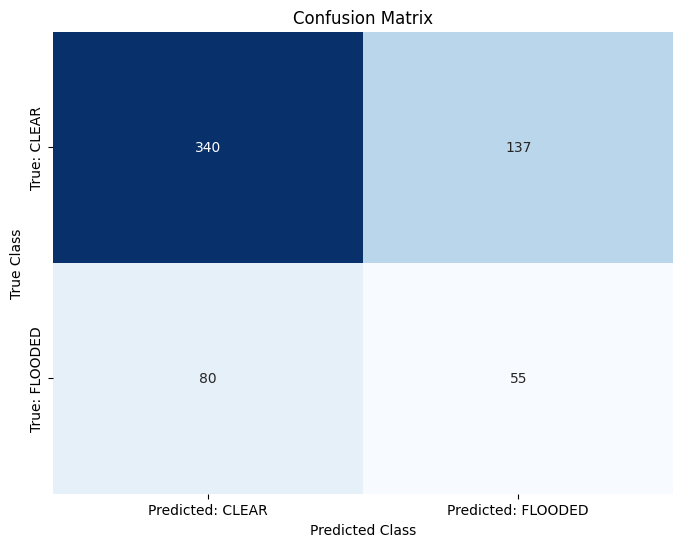

In [42]:
data = pd.read_csv("classification_results.csv")
tp = ((data['predicted_class'] == "FLOODED") & (data['true_class'] == "FLOODED")).sum()
tn = ((data['predicted_class'] == "CLEAR") & (data['true_class'] == "CLEAR")).sum()
fp = ((data['predicted_class'] == "FLOODED") & (data['true_class'] == "CLEAR")).sum()
fn = ((data['predicted_class'] == "CLEAR") & (data['true_class'] == "FLOODED")).sum()


conf_matrix = pd.DataFrame([[tn, fp], [fn, tp]],
                           columns=["Predicted: CLEAR", "Predicted: FLOODED"],
                           index=["True: CLEAR", "True: FLOODED"])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Calculate class balances:

In [39]:
class_counts = data['true_class'].value_counts()
total_samples = len(data)

for class_name, count in class_counts.items():
    balance = count / total_samples
    print(f"Class '{class_name}' Balance: {balance:.2f}")

Class 'CLEAR' Balance: 0.78
Class 'FLOODED' Balance: 0.22


Calculate evaluation metrics:

In [44]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


summary = pd.DataFrame({
    "Metric": ["True Positives", "True Negatives", "False Positives", "False Negatives"],
    "Count": [tp, tn, fp, fn]
})
print("\nConfusion Matrix:")
print(summary)


y_true = data['true_class']
y_pred = data['predicted_class']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["CLEAR", "FLOODED"], zero_division=0))


Accuracy: 0.65
Precision: 0.29
Recall: 0.41
F1-Score: 0.34

Confusion Matrix:
            Metric  Count
0   True Positives     55
1   True Negatives    340
2  False Positives    137
3  False Negatives     80

Classification Report:
              precision    recall  f1-score   support

       CLEAR       0.81      0.71      0.76       477
     FLOODED       0.29      0.41      0.34       135

    accuracy                           0.65       612
   macro avg       0.55      0.56      0.55       612
weighted avg       0.69      0.65      0.67       612



#### Summary of Metrics:
- **Accuracy:** The proportion of correctly classified samples compared to all samples.
- **Precision:** Out of all positive predictions, how many were correct (a measure of avoiding false alarms).
- **Recall (Sensitivity):** Out of all actual positive cases, how many were correctly identified by the model (a measure of sensitivity).
- **F1-Score:** The harmonic mean of Precision and Recall, providing a balanced performance metric.

#### Averaging Methods:
- **Macro Average:** The simple (unweighted) average of metrics for all classes, independent of class sizes.
- **Weighted Average:** The weighted average of metrics for all classes, taking into account the proportion of examples in each class in the dataset.

Plot the ROC and PR curve based on the results:

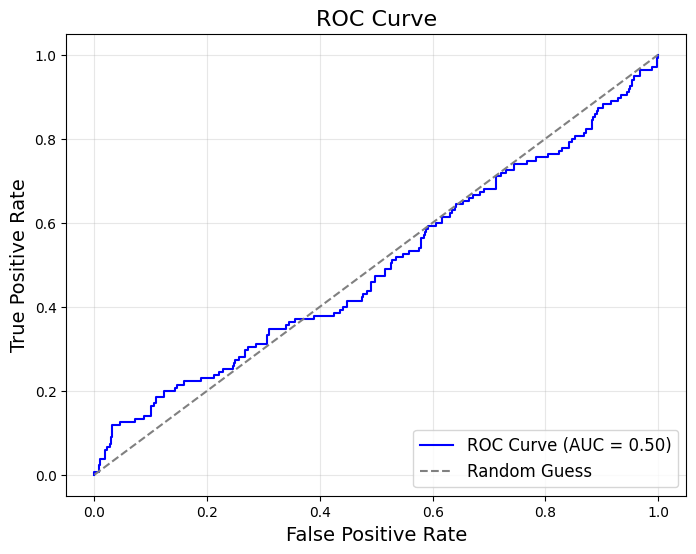

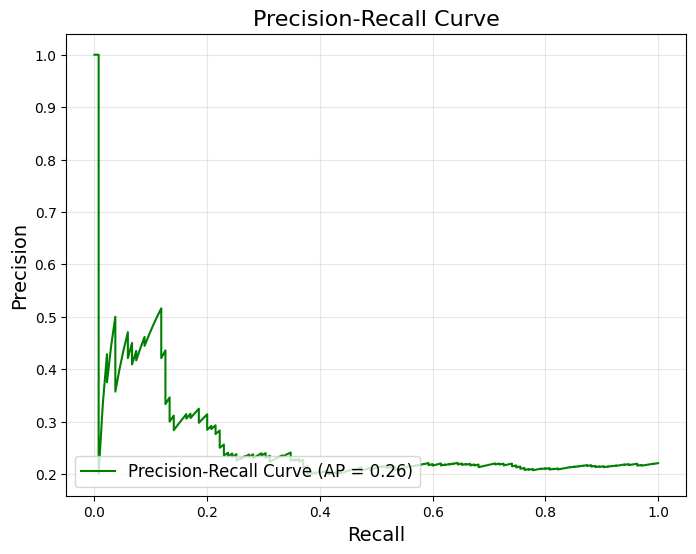

In [46]:
# Convert true and predicted classes to binary for ROC and PR curve calculations
data['true_class_binary'] = (data['true_class'] == "FLOODED").astype(int)

fpr, tpr, thresholds = roc_curve(data['true_class_binary'], data['predicted_probability'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


precision, recall, thresholds = precision_recall_curve(data['true_class_binary'], data['predicted_probability'])
average_precision = average_precision_score(data['true_class_binary'], data['predicted_probability'])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.title("Precision-Recall Curve", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.legend(loc="lower left", fontsize=12)
plt.grid(alpha=0.3)
plt.show()



---

2024.12.08

Szladek Máté Nándor - TGPZTT

Tóth Ádám László - TK6NT3